# hw4 - NN pyTorch

Во всем задании вы должны работать со входом из строк размером (длиной) 1024

## Часть 1 Фурье

### Подготовка данных

Сгенерите данные (сигнал) любым пакетом для численного преобразования Фурье, [например](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

>Тут пробую сгенерить и посмотреть на один сигнал и его fft

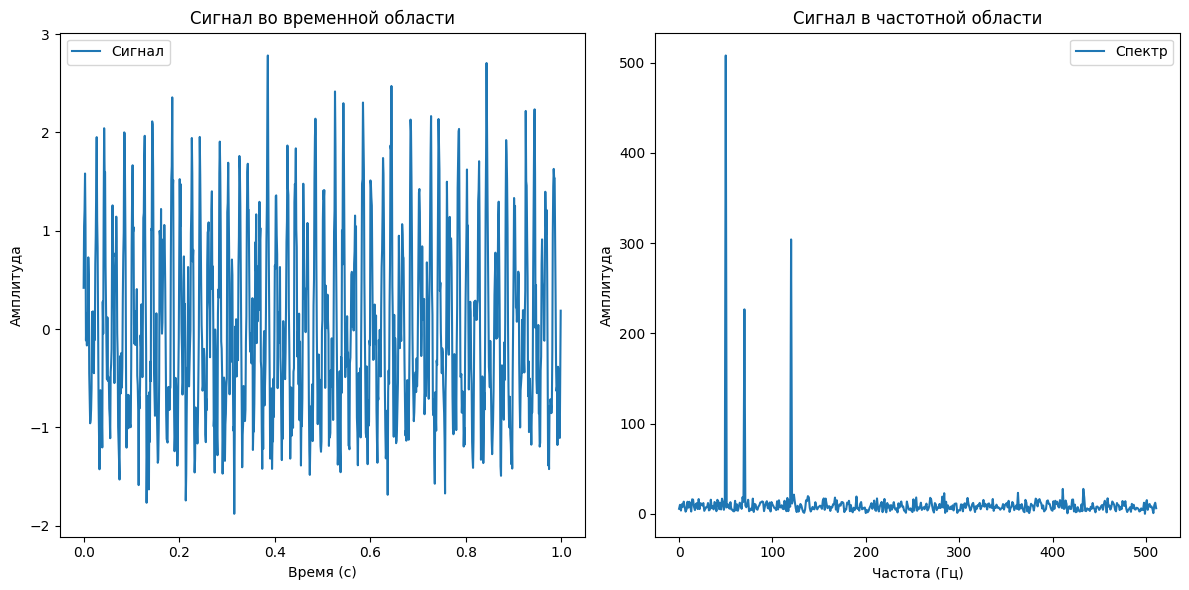

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def generate_signal(length):
    t = np.linspace(0, 1, length, endpoint=False) # временные отсчеты (1 секунда, 1024 точки)
    signal = (
        np.sin(2 * np.pi * 50 * t) +    # синус с частотой 50 Гц
        0.6 * np.sin(2 * np.pi * 120 * t) +  # синус с частотой 120 Гц
        0.4 * np.cos(2 * np.pi * 70 * t) +  # косинус 70 Гц
        0.3 * np.random.randn(length)  # случайный шум
    )
    return signal

fs = 1024  # частота
t = np.linspace(0, 1, fs, endpoint=False)

signal = generate_signal(1024)

# Преобразование Фурье
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(t), 1 / fs)  # частоты (оси для спектра)

# модуль спектра
fft_magnitude = np.abs(fft_result)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t, signal, label="Сигнал")
plt.title("Сигнал во временной области")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(frequencies[:len(frequencies)//2], fft_magnitude[:len(frequencies)//2], label="Спектр")
plt.title("Сигнал в частотной области")
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда")
plt.legend()

plt.tight_layout()
plt.show()

>Теперь делаем много таких сигналов

In [114]:
n_samples = 1000  # количество примеров в выборке
signal_length = 1024

# генерация
signals = np.array([generate_signal(signal_length) for _ in range(n_samples)])

fft_signals = np.fft.fft(signals)
fft_magnitudes = np.abs(fft_signals)  # модуль спектра

In [115]:
fft_magnitudes.shape

(1000, 1024)

### Соберите и обучите нейросетку на pyTroch для преобразования Фурье

final loss: 19.891891479492188


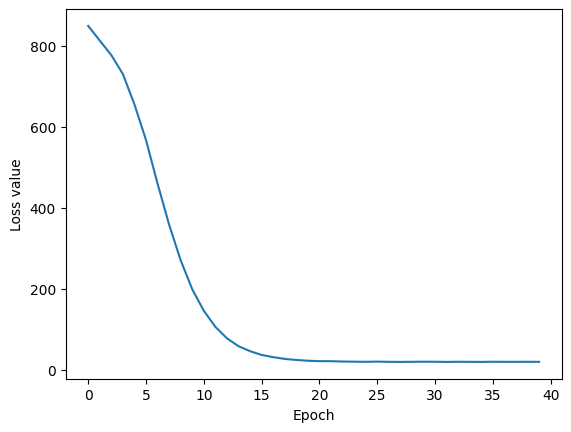

In [116]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# в тензоры это всё..
X_train = torch.tensor(signals, dtype=torch.float32)
y_train = torch.tensor(fft_magnitudes, dtype=torch.float32)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

class FFTNet(nn.Module):
    def __init__(self, input_size):
        super(FFTNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, input_size),
        ) # даже такой простенькой уже достаточно

    def forward(self, x):
        return self.net(x)


model = FFTNet(input_size=signal_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


epochs = 40
history = [] # для визуализации лосса

for epoch in range(epochs):
    for x, y in dataloader:
        predictions = model(x)
        loss = criterion(predictions, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    history.append(loss.item())

print("final loss:", history[-1])
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

### Сравните свое решение с пакетным методом

> Просто ещё раз заново генерим и преобразуем сигнал для валидации

Среднеквадратичная ошибка (MSE): 21.414029


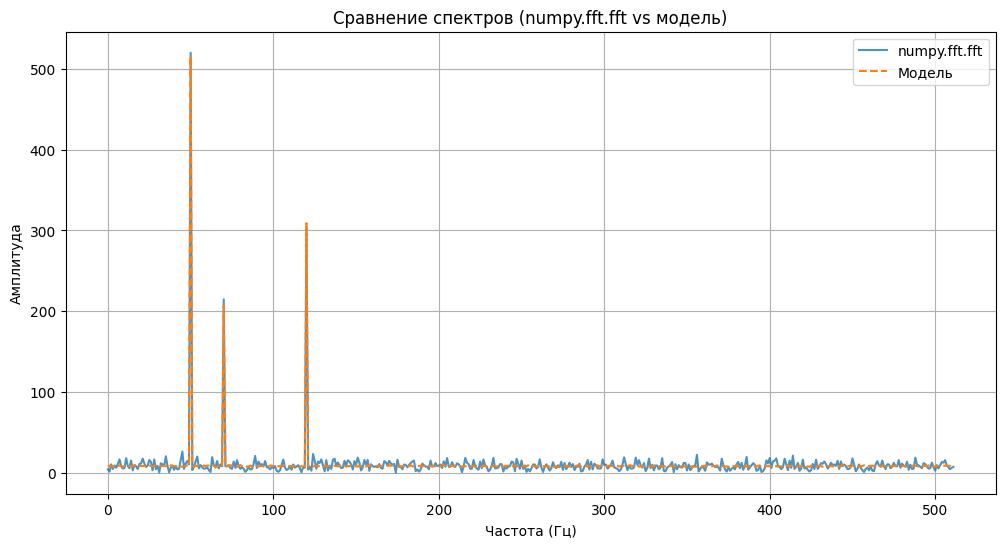

In [117]:
test_signal = generate_signal(signal_length)

# библиотека
fft_numpy = np.abs(np.fft.fft(test_signal))

test_signal_tensor = torch.tensor(test_signal, dtype=torch.float32).unsqueeze(0)

# модель
model.eval()
with torch.no_grad():
    fft_model = model(test_signal_tensor).squeeze().numpy()

#mse
mse = np.mean((fft_numpy - fft_model) ** 2)
print(f"MSE: {mse:.3f}")


frequencies = np.fft.fftfreq(len(t), 1 / fs)

plt.figure(figsize=(12, 6))

plt.plot(frequencies[:len(frequencies)//2], fft_numpy[:len(frequencies)//2], label="numpy.fft.fft", alpha=0.8)
plt.plot(frequencies[:len(frequencies)//2], fft_model[:len(frequencies)//2], label="Модель", alpha=1, linestyle='--')

plt.title("Сравнение спектров (numpy.fft.fft vs модель)")
plt.xlabel("Частота (Гц)")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid()
plt.show()

## Часть 2 Power spectral density (dB)

### Подготовка данных

Используя пакетное решение, [например](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html), подготовьте обучающую выборку.

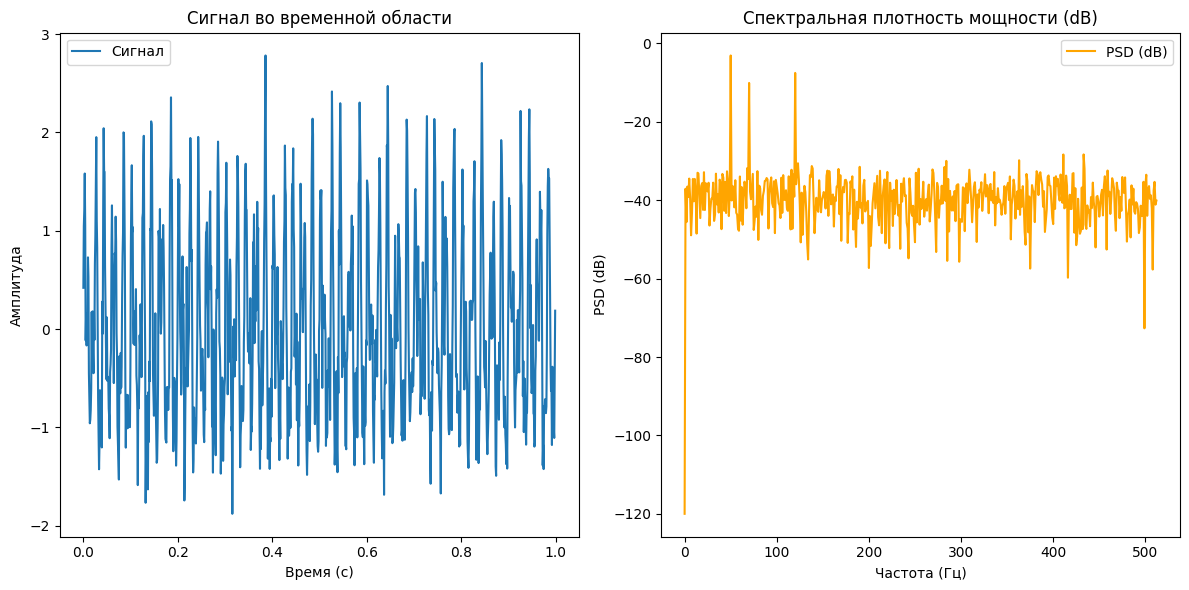

In [118]:
from scipy.signal import periodogram

# беру такой же сигнал как в первой части
frequencies, psd = periodogram(signal, fs)
psd_db = 10 * np.log10(psd + 1e-12)  # перевод в dB и добавка чтобы не поделить на 0


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t, signal, label="Сигнал")
plt.title("Сигнал во временной области")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(frequencies, psd_db, label="PSD (dB)", color='orange')
plt.title("Спектральная плотность мощности (dB)")
plt.xlabel("Частота (Гц)")
plt.ylabel("PSD (dB)")
plt.legend()

plt.tight_layout()
plt.show()

### Соберите и обучите нейросеть для предсказания спектральной плотности мощности

*Подсказка: для входа 1024 выход будет 512*

final loss: 30.99465262889862


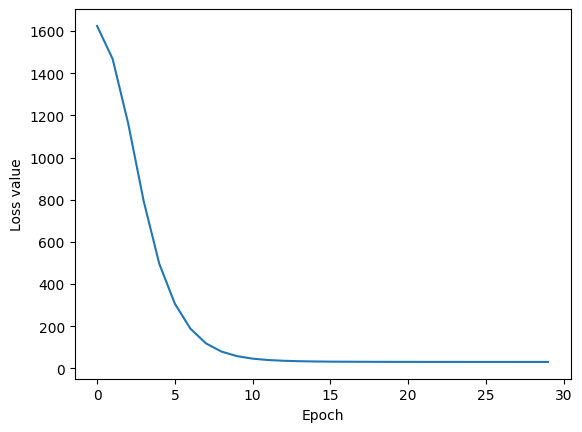

In [119]:
psd_db_outputs = np.array([
    10 * np.log10(periodogram(sig, fs)[1] + 1e-12)  # чтобы не было деления на 0
    for sig in signals
])  # PSD в dB

X_train = torch.tensor(signals, dtype=torch.float32)
y_train = torch.tensor(psd_db_outputs, dtype=torch.float32)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


# 513 т.к. Функция periodogram возвращает PSD с длиной N/2+1, где N — длина сигнала.
class PSDNet(nn.Module):
    def __init__(self, input_size=1024, output_size=513):
        super(PSDNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
        )

    def forward(self, x):
        return self.net(x)


model = PSDNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 30
history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    history.append(epoch_loss / len(dataloader))


print("final loss:", history[-1])
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

### Провалидируйте свое решение

*Примечание: Для сдачи достаточно качественного соответствия по форме спектра с пакетным решением*

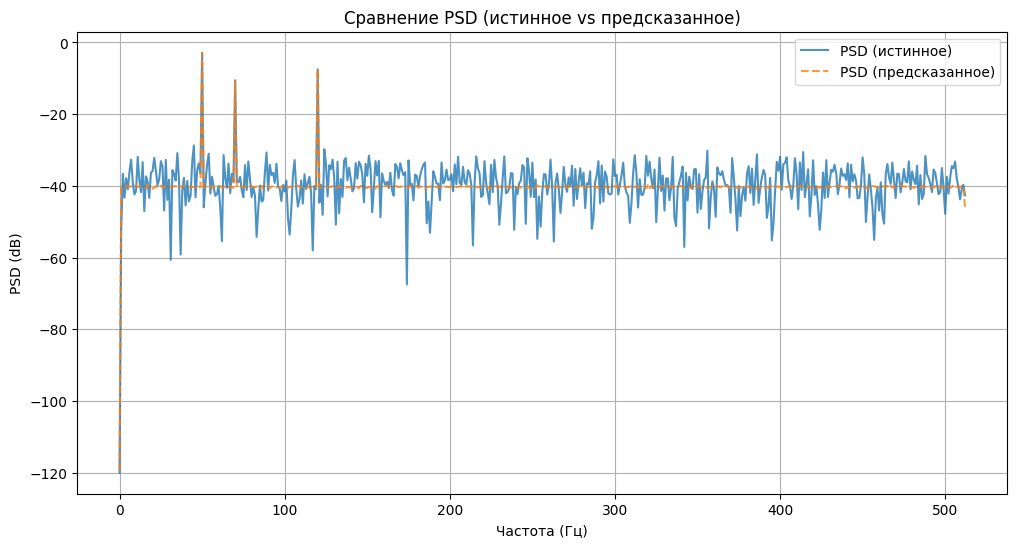

In [120]:
# беру тест сигнал из части 1
frequencies, psd = periodogram(test_signal, fs)
psd_db_true = 10 * np.log10(psd + 1e-12)


test_signal_tensor = torch.tensor(test_signal, dtype=torch.float32).unsqueeze(0)

model.eval()
with torch.no_grad():
    psd_db_pred = model(test_signal_tensor).squeeze().numpy()


plt.figure(figsize=(12, 6))
plt.plot(frequencies, psd_db_true, label="PSD (истинное)", alpha=0.8)
plt.plot(frequencies, psd_db_pred, label="PSD (предсказанное)", alpha=0.8, linestyle='--')
plt.title("Сравнение PSD (истинное vs предсказанное)")
plt.xlabel("Частота (Гц)")
plt.ylabel("PSD (dB)")
plt.legend()
plt.grid()
plt.show()